# JobSpark - Job Recommendations

Job Recommendations using Content-Based Filtering

## Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

## Data Load and Preprocessing


In [ ]:
dataset = pd.read_csv('dataset_loker_downsynd.csv')

print("Dataset Overview:")
print(dataset.head())

Dataset Overview:
      Nama Pekerjaan                Perusahaan      Lokasi          Gaji  \
0      Asisten Dapur         PT Roti Nusantara     Jakarta  Rp 2.500.000   
1      Petugas Kebun        Taman Kota Mandiri     Bandung  Rp 2.000.000   
2  Operator Komputer           PT Digital Jaya    Surabaya  Rp 3.000.000   
3  Pembersih Ruangan       PT Bersih Sejahtera  Yogyakarta  Rp 2.200.000   
4  Fotografer Pemula  Studio Kreatif Nusantara    Denpasar  Rp 3.500.000   

                                 Deskripsi Pekerjaan       Kategori Minat  \
0  Membantu koki menyiapkan bahan masakan dan men...              Memasak   
1  Merawat tanaman, menyiram bunga, dan menjaga k...             Berkebun   
2  Mengoperasikan komputer untuk tugas-tugas sede...      Teknologi dasar   
3  Membersihkan ruangan kerja dan menjaga kebersi...  Lingkungan dan alam   
4  Mengambil foto sederhana dan membantu pengedit...      Fotografi, Seni   

                                Kemampuan Dibutuhkan  \
0  Men

In [ ]:
dataset['Kategori Minat'] = dataset['Kategori Minat'].fillna('')
dataset['Kemampuan Dibutuhkan'] = dataset['Kemampuan Dibutuhkan'].fillna('')
dataset['Kondisi Kesehatan'] = dataset['Kondisi Kesehatan'].fillna('')

dataset['Kategori Minat'] = dataset['Kategori Minat'].str.split(', ')
dataset['Kemampuan Dibutuhkan'] = dataset['Kemampuan Dibutuhkan'].str.split(', ')
dataset['Kondisi Kesehatan'] = dataset['Kondisi Kesehatan'].str.split(', ')

In [ ]:
minat_encoder = MultiLabelBinarizer()
skills_encoder = MultiLabelBinarizer()
kondisi_encoder = MultiLabelBinarizer()

minat_encoded = minat_encoder.fit_transform(dataset['Kategori Minat'])
skills_encoded = skills_encoder.fit_transform(dataset['Kemampuan Dibutuhkan'])
kondisi_encoded = kondisi_encoder.fit_transform(dataset['Kondisi Kesehatan'])

## Feature Engineering with Weights

In [ ]:
job_features = np.hstack([
    minat_encoded * 0.6,
    skills_encoded * 0.3,
    kondisi_encoded * 0.1
])

In [ ]:
X_train, X_test = train_test_split(job_features, test_size=0.2, random_state=42)

## Model Definition and Training

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, X_train, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.0426 - loss: 0.6937 - val_accuracy: 0.0000e+00 - val_loss: 0.6854
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0209 - loss: 0.6834 - val_accuracy: 0.0000e+00 - val_loss: 0.6748
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0087 - loss: 0.6713 - val_accuracy: 0.0000e+00 - val_loss: 0.6571
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0152 - loss: 0.6524 - val_accuracy: 0.0000e+00 - val_loss: 0.6292
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0078 - loss: 0.6228 - val_accuracy: 0.0000e+00 - val_loss: 0.5874
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0130 - loss: 0.5785 - val_accuracy: 0.0000e+00 - val_loss: 0.5273
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0035 - loss: 0.5135 - val_accuracy: 0.0000e+00 - val_loss: 0.4472
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 

## Visualization

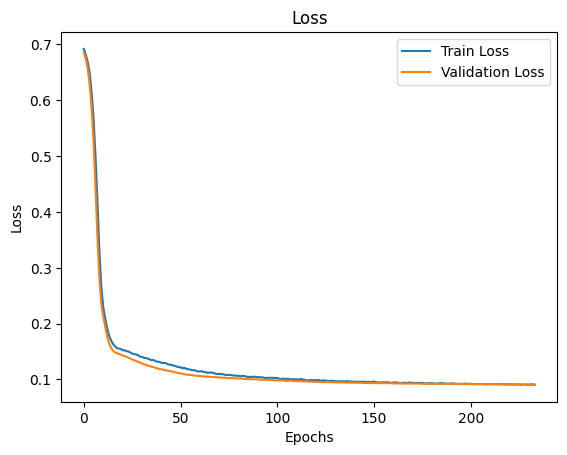

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Recommendation System

In [ ]:
def rekomendasi_jobspark(minat_user, dataset, minat_encoder, skills_encoder, kondisi_encoder, model, kemampuan_user, kondisi_user, top_n=5):
    user_minat_vector = minat_encoder.transform([minat_user])

    user_skills_vector = np.zeros((user_minat_vector.shape[0], skills_encoded.shape[1]))
    user_conditions_vector = np.zeros((user_minat_vector.shape[0], kondisi_encoded.shape[1]))

    user_vector = np.hstack([
        user_minat_vector * 0.6,
        user_skills_vector * 0.3,
        user_conditions_vector * 0.1
    ])

    user_prediction = model.predict(user_vector.reshape(1, -1))

    nilai_similaritas = cosine_similarity(user_prediction, job_features)

    similiaritas_indeks = nilai_similaritas[0].argsort()[-top_n-1:-1][::-1]

    print("Top Recommendations:")
    for i in similiaritas_indeks:
        rekomendasi_jobspark = dataset.iloc[i]
        print(f"Nama Pekerjaan: {rekomendasi_jobspark['Nama Pekerjaan']}")
        print(f"Perusahaan: {rekomendasi_jobspark['Perusahaan']}")
        print(f"Lokasi: {rekomendasi_jobspark['Lokasi']}")
        print(f"Kualifikasi: {rekomendasi_jobspark['Kualifikasi']}")
        print(f"Minimal Pengalaman: {rekomendasi_jobspark['Minimal Pengalaman']}")
        print(f"Kategori Minat: {rekomendasi_jobspark['Kategori Minat']}")
        print(f"Kemampuan Dibutuhkan: {rekomendasi_jobspark['Kemampuan Dibutuhkan']}")
        print(f"Kondisi Kesehatan: {rekomendasi_jobspark['Kondisi Kesehatan']}")
        print("-" * 40)

## Testing the Recommendation System

In [ ]:
kategori_minat = [
    "Seni", "Musik", "Menari", "Kerajinan tangan", "Berkebun",
    "Memasak", "Merawat hewan",
    "Teknologi dasar", "Fotografi", "Lingkungan dan alam"
]

kategori_kemampuan = [
    "Membaca dasar", "Menulis sederhana", "Mendengarkan instruksi",
    "Berbicara dengan orang lain", "Kerja tim", "Ketelitian",
    "Koordinasi tangan dan mata", "Kesabaran", "Kreativitas",
    "Mengikuti langkah-langkah sederhana", "Menggunakan alat sederhana",
    "Pemecahan masalah sederhana", "Mandiri dengan supervisi",
    "Menjaga kebersihan", "Mengatur waktu", "Ketahanan fisik ringan"
]

kategori_kesehatan = [
    "Menggunakan kursi roda", "Membutuhkan kacamata",
    "Menggunakan alat bantu dengar", "Kesulitan berdiri terlalu lama",
    "Tidak boleh mengangkat beban berat", "Membutuhkan lingkungan kerja tenang",
    "Tidak cocok di suhu panas", "Tidak cocok di suhu dingin",
    "Alergi bahan kimia tertentu", "Membutuhkan istirahat berkala"
]

minat_dropdown = widgets.Dropdown(
    options=kategori_minat,
    description='Minat:',
)

kemampuan_dropdown = widgets.Dropdown(
    options=kategori_kemampuan,
    description='Kemampuan:',
)

kondisi_dropdown = widgets.Dropdown(
    options=kategori_kesehatan,
    description='Kondisi Kesehatan:',
)

recommend_button = widgets.Button(description="Dapatkan Rekomendasi")

def on_button_click(b):
    minat_user = [minat_dropdown.value]
    kemampuan_user = [kemampuan_dropdown.value]
    kondisi_user = [kondisi_dropdown.value]

    rekomendasi_jobspark(minat_user, dataset, minat_encoder, skills_encoder, kondisi_encoder, model, kemampuan_user, kondisi_user)

recommend_button.on_click(on_button_click)

display(minat_dropdown, kemampuan_dropdown, kondisi_dropdown, recommend_button)

Dropdown(description='Minat:', options=('Seni', 'Musik', 'Menari', 'Kerajinan tangan', 'Berkebun', 'Memasak', …

Dropdown(description='Kemampuan:', options=('Membaca dasar', 'Menulis sederhana', 'Mendengarkan instruksi', 'B…

Dropdown(description='Kondisi Kesehatan:', options=('Menggunakan kursi roda', 'Membutuhkan kacamata', 'Menggun…

Button(description='Dapatkan Rekomendasi', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Top Recommendations:
Nama Pekerjaan: Staf Produksi Produk Kreatif
Perusahaan: PT Produk Inovasi
Lokasi: Jakarta
Kualifikasi: Lulusan SMP/SMK
Minimal Pengalaman: 0-1 tahun
Kategori Minat: ['Seni', 'Kerajinan tangan']
Kemampuan Dibutuhkan: ['Kreativitas', 'Koordinasi tangan dan mata', 'Ketelitian']
Kondisi Kesehatan: ['Tidak cocok di suhu dingin', 'Membutuhkan lingkungan kerja tenang']
----------------------------------------
Nama Pekerjaan: Asisten Desain Pakaian
Perusahaan: Studio Fashion Nusantara
Lokasi: Medan
Kualifikasi: Lulusan SMA/SMK
Minimal Pengalaman: 1-2 tahun
Kategori Minat: ['Seni', 'Kerajinan tangan']
Kemampuan Dibutuhkan: ['Kreativitas', 'Koordinasi tangan dan mata', 'Ketelitian']
Kondisi Kesehatan: ['Membutuhkan lingkungan kerja tenang']
----------------------------------------
Nama Pekerjaan: Perajin Mainan Edukasi
Perusahaan: Studio Mainan Nusantara
Lokasi: Solo
Kualifikasi: Lulusan SMP/SMK
Minimal Pengalaman: 0-1 tahun
Kategori Mi

## Exporting Model

In [ ]:
from google.colab import files

model.save('model_sisrek_jobspark.keras')
dataset.to_csv('dataset_loker_downsynd_exported.csv', index=False)

files.download('model_sisrek_jobspark.keras')
files.download('dataset_loker_downsynd_exported.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>